https://towardsdatascience.com/cifar-100-transfer-learning-using-efficientnet-ed3ed7b89af2

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

2023-05-31 11:52:39.768750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TEST_PATH = "dataset/test/"
TEST_TOP10_PATH = "dataset/test_top10/"
TEST_LAST10_PATH = "dataset/test_last10/"
TEST_DIRS = glob.glob("dataset/test/*")
TEST_TOP10_DIRS = glob.glob("dataset/test_top10/*")
TEST_LAST10_DIRS = glob.glob("dataset/test_last10/*")

MODELS = ["food-seg-103-xception", "food-seg-103-densenet121", "food-seg-103-densenet201"]
CHECKPOINT_PATHS = ["checkpoints/" + MODEL + ".h5" for MODEL in MODELS]
MODEL_PATHS = ["models/" + MODEL + ".h5" for MODEL in MODELS]

IMAGE_SIZE = 512

In [3]:
def acc_top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [4]:
def load_models():
    loaded_models = []
    for CHECKPOINT_PATH in CHECKPOINT_PATHS:
        loaded_models.append(load_model(CHECKPOINT_PATH, custom_objects={"acc_top5": acc_top5}))
    print("Models Loaded")
    return loaded_models

In [5]:
models = load_models()

Models Loaded


In [6]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_data = test_datagen.flow_from_directory(
    TEST_PATH,
    batch_size=1,
    shuffle=False,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical")
filenames = test_data.filenames

Found 9832 images belonging to 104 classes.


In [7]:
def evaluate(model):
    test_score = model.evaluate(test_data)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    print("Test Accuracy Top 5: ", test_score[2])

In [8]:
for i, model in enumerate(models):
    print("=" * 100)
    print(MODELS[i])
    evaluate(model)
    print("=" * 100)

food-seg-103-xception


2023-05-30 20:47:45.229514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9832/9832 [==============================] - 3251s 331ms/step - loss: 1.3146 - accuracy: 0.6558 - acc_top5: 0.8777
Test Loss:  1.314602255821228
Test Accuracy:  0.6558177471160889
Test Accuracy Top 5:  0.8777461647987366
food-seg-103-densenet121


2023-05-30 21:41:56.099835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9832/9832 [==============================] - 4138s 421ms/step - loss: 1.4145 - accuracy: 0.6366 - acc_top5: 0.8686
Test Loss:  1.4145026206970215
Test Accuracy:  0.6365947723388672
Test Accuracy Top 5:  0.8685923218727112
food-seg-103-densenet201


2023-05-30 22:50:54.457382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9832/9832 [==============================] - 6828s 694ms/step - loss: 1.3357 - accuracy: 0.6460 - acc_top5: 0.8742
Test Loss:  1.3356807231903076
Test Accuracy:  0.6459519863128662
Test Accuracy Top 5:  0.8741863369941711


In [9]:
def predict(model):
    predicted_class_indices = []

    with tqdm(total=len(test_data.filepaths)) as pbar:
        for i, filepath in enumerate(test_data.filepaths):
            pbar.set_description("Predicting: %d" % (1 + i))
            pbar.update(1)
            test_image = load_img(filepath, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            test_image_array = img_to_array(test_image)
            test_image_array = np.expand_dims(test_image_array, axis=0)
            test_image_array = test_image_array / 255.
            prediction = model.predict(test_image_array, verbose=0)
            predicted_label = np.argmax(prediction)
            predicted_class_indices.append(predicted_label)
    
    predicted_class_indices = np.asarray(predicted_class_indices)

    predicted_classnames = []
    true_classnames = []
    for i in range(len(filenames)):
        predicted_classnames.append(list(test_data.class_indices.keys())[predicted_class_indices.item(i)])
        true_classnames.append(list(test_data.class_indices.keys())[test_data.labels[i]])
    return pd.DataFrame({"Filename": filenames, "Prediction": predicted_classnames, "True": true_classnames})

In [10]:
results = []
for model in models:
    results.append(predict(model))

Predicting: 9832: 100%|███████████████████| 9832/9832 [1:59:38<00:00,  1.37it/s]


In [11]:
mismatched_results = []
for i, result in enumerate(results):
    test_accuracy = result.loc[(result["Prediction"] == result["True"])].shape[0] / result.shape[0]
    mismatched_result = result.loc[~(result["Prediction"] == result["True"])]
    mismatched_results.append(mismatched_result)
    print(MODELS[i] + ": " + "Test Accuracy: " + str(test_accuracy) + ", Mismatch: " + str(len(mismatched_result)))

food-seg-103-xception: Test Accuracy: 0.6558177379983726, Mismatch: 3384
food-seg-103-densenet121: Test Accuracy: 0.6365947925142392, Mismatch: 3573
food-seg-103-densenet201: Test Accuracy: 0.6459519934906428, Mismatch: 3481


In [12]:
results[0].sample(10)

,Filename,Prediction,True
7329,pie/00006097.png,pie,pie
3314,broccoli/00006039.png,broccoli,broccoli
8813,spring onion/00007093.png,spring onion,spring onion
7129,pepper/00005530.png,cucumber,pepper
2992,bread/00006052.png,cake,bread
2879,bread/00005495.png,bread,bread
3663,carrot/00005044.png,carrot,carrot
4979,coffee/00006186.png,coffee,coffee
9831,wonton dumplings/00007060.png,tomato,wonton dumplings
4130,cheese butter/00005115.png,French beans,cheese butter


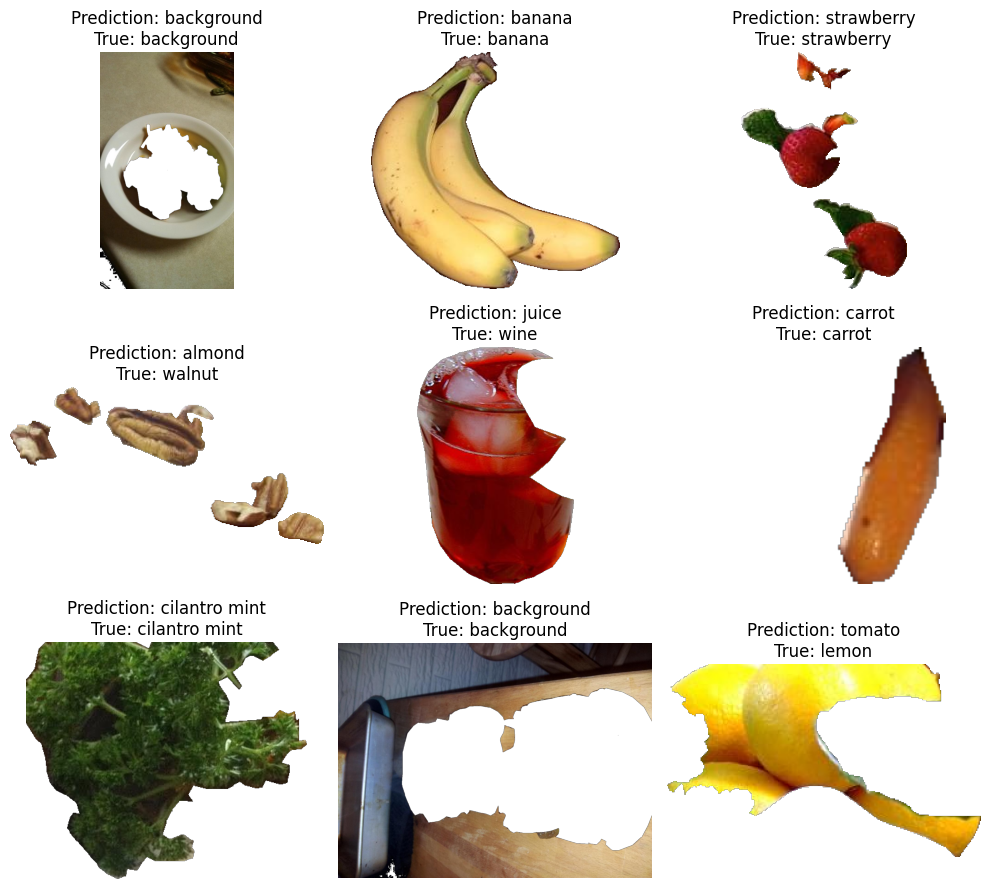

In [13]:
plt.figure(figsize=(10, 9))

for idx, row in results[0].sample(9).reset_index(drop=True).iterrows():
    plt.subplot(3, 3, idx + 1)
    img = plt.imread(TEST_PATH + row["Filename"])
    plt.title("Prediction: " + row["Prediction"] + "\nTrue: " + row["True"])
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.tight_layout()

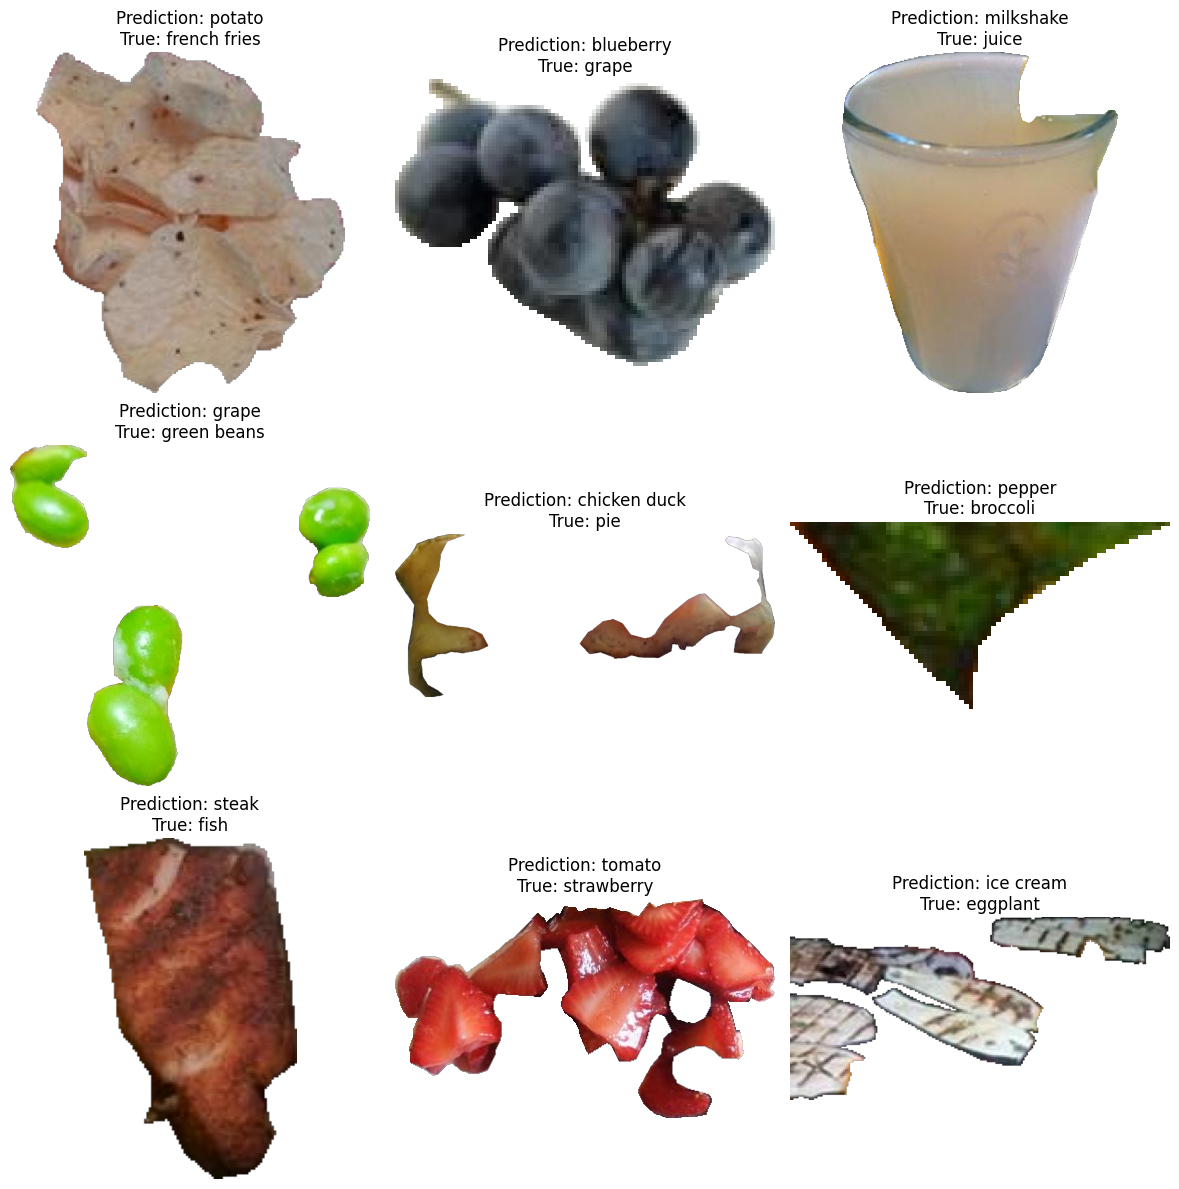

In [14]:
plt.figure(figsize=(12, 12))

for idx, row in mismatched_results[0].sample(9).reset_index(drop=True).iterrows():
    plt.subplot(3, 3, idx + 1)
    img = plt.imread(TEST_PATH + row["Filename"])
    plt.title("Prediction: " + row["Prediction"] + "\nTrue: " + row["True"])
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.tight_layout()

In [15]:
ensemble_result = {}
for i, result in enumerate(results):
    ensemble_result[i] = result["Prediction"]
ensemble_result["True"] = results[0]["True"]
ensemble_result = pd.DataFrame(ensemble_result)
ensemble_result.sample(10)

,0,1,2,True
8524,cheese butter,sauce,cauliflower,sauce
2248,background,background,background,background
1388,background,background,background,background
6710,onion,onion,onion,onion
6237,potato,potato,cake,lemon
7348,sauce,other ingredients,avocado,pie
5352,egg,banana,egg,egg
9401,tomato,tomato,tomato,tomato
8572,sausage,sausage,sausage,sausage
6299,lemon,lemon,lemon,lemon


In [16]:
def get_ensemble_result():
    truth = 0
    for index, row in ensemble_result.iterrows():
        predictions = list(row)[:-1]
        prediction = max(set(predictions), key=predictions.count)
        label = list(row)[-1:][0]
        if prediction == label:
            truth += 1
    return truth / ensemble_result.shape[0]

In [17]:
print("Ensemble Test Accuracy: " + str(get_ensemble_result()))

Ensemble Test Accuracy: 0.6718877135882831
